<a href="https://colab.research.google.com/github/JungOhLee/GDL_pytorch/blob/shcho/shcho_chapter5_20200418_v15_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import auth
auth.authenticate_user()
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import itertools

In [0]:
from torch import nn
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import  tarfile
from torchsummary import summary as ptsum
import torch.autograd as autograd
# import png

from PIL import Image
from torch.autograd import Variable

import cv2

In [0]:
import numpy as np
import os
import matplotlib.pyplot as plt
import collections
from torch.autograd import Variable
import warnings
warnings.filterwarnings(action='ignore')

from zipfile import ZipFile

from tqdm import tqdm_notebook as tqdm

In [0]:
from PIL import Image

In [0]:
# from keras.applications import vgg19
from keras import backend as K

Using TensorFlow backend.


In [0]:
import torchvision.transforms as transforms
import torchvision.models as models

In [0]:
import copy

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

https://tutorials.pytorch.kr/advanced/neural_style_tutorial.html

In [0]:
imsize = 512 if torch.cuda.is_available() else 128  # gpu가 없다면 작은 크기로

In [0]:
loader = transforms.Compose([
    transforms.Resize(imsize),  # 입력 영상 크기를 맞춤
    transforms.ToTensor()])  # 토치 텐서로 변환

In [0]:
def image_loader(image_name, on_gpu = True):
    image = Image.open(image_name)
    # 네트워크의 입력 차원을 맞추기 위해 필요한 가짜 배치 차원
    image = loader(image).unsqueeze(0)
    if on_gpu:
      return image.to(device, torch.float)
    else:
      return image.float()

## Image Loading Example


In [0]:
image = Image.open('./drive/My Drive/Colab Notebooks/mlstudy/gan/gdl_code/data/picasso.jpg')

In [0]:
image = loader(image).unsqueeze(0)

In [0]:
# 꼭 이렇게 두번 바꿔야하나?
image_np = image[0].transpose(0,1).transpose(1,2)

In [0]:
image_np.shape

torch.Size([512, 512, 3])

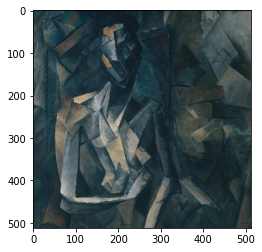

In [0]:
plt.imshow(image_np)

# Change Directory

In [0]:
os.chdir('./drive/My Drive/Colab Notebooks/mlstudy/gan/gdl_code/')

In [0]:
_style_img_raw = image_loader("./data/picasso.jpg", False)
# _content_img = image_loader("./data/dancing.jpg", False)
_content_img = image_loader("./data/KakaoTalk_20200418_150028084.jpg", False)

_style_img = _style_img_raw[:,:,:,110:-110]
# _style_img.shape

In [0]:
_content_img_raw = image_loader("./data/sixpack.jpg", False)
# _content_img = image_loader("./data/dancing.jpg", False)
_style_img_raw = image_loader("./data/KakaoTalk_20200418_150028084.jpg", False)

_style_img = _style_img_raw[:,:,-512:,:]
_content_img = _content_img_raw[:,:,:,110:-110]

In [0]:
_style_img_raw.shape, _content_img_raw.shape

(torch.Size([1, 3, 682, 512]), torch.Size([1, 3, 512, 732]))

In [0]:
_style_img.shape, _content_img.shape

(torch.Size([1, 3, 512, 512]), torch.Size([1, 3, 512, 512]))

In [0]:
style_img = _style_img.to(device)
content_img = _content_img.to(device)

In [0]:
unloader = transforms.ToPILImage()

In [0]:
def pt_imshow(tensor, title=None):
    image = tensor.cpu().clone()  # 텐서의 값에 변화가 적용되지 않도록 텐서를 복제합니다
    image = image.squeeze(0)      # 페이크 배치 차원을 제거 합니다
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # 그리는 부분이 업데이트 될 수 있게 잠시 정지합니다

In [0]:
vgg19pt = models.vgg19(pretrained=True).features #.to(device).eval()
vgg19pt.eval()
print('Loaded.')

Loaded.


In [0]:
list_layer = []
for layer in vgg19pt.children():
  list_layer.append(layer)

In [0]:
layer_example = copy.deepcopy(list_layer[0])

In [0]:
layer_example

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [0]:
for p in layer_example.parameters():
  pass

In [0]:
p

Parameter containing:
tensor([-0.9130,  0.3068, -1.3064, -0.7762, -0.7888, -0.4155,  0.2666, -0.8560,
         0.3901,  0.1206,  0.2143,  0.3767,  0.2672, -0.8205,  0.0463,  0.4325,
         0.3040, -0.1048,  0.4146,  0.3701,  0.4728,  0.4447,  0.1775, -1.1050,
         0.3911, -0.8114,  0.0029,  0.2943,  0.2926,  0.5354,  0.4415,  0.4302,
         0.5140,  0.4039,  0.4905,  0.3326,  0.3844,  0.3955,  0.4361,  0.2157,
         0.2640,  0.3557, -0.7006, -0.0398,  0.1095, -1.2560,  0.0400, -0.2300,
         0.0763, -0.4009, -0.8053,  0.3830, -0.2696, -0.3153,  0.4309,  0.3720,
        -0.2352, -0.2580,  0.2720,  0.2830, -0.2227, -0.1897,  0.3060,  0.3920],
       requires_grad=True)

## 파이토치에서는... 그 content loss를 계산하는 층을 직접만들어주는 것이 정석인가보네

In [0]:
class ContentLoss(nn.Module):
  def __init__(self, base_img):
    super(ContentLoss, self).__init__()
    self.base_img = base_img.detach()
    self.content_loss = nn.MSELoss()
    self.loss = None

  def forward(self, x):

    self.loss = self.content_loss(self.base_img, x)

    return x

In [0]:
testlayer = ContentLoss(content_img)

## 그람 행렬은 각 채널 output 간의 correlation matrix이다.

In [0]:
conv2d_eg = nn.Conv2d(3, 16, 3, 1).to(device)

In [0]:
output = conv2d_eg(style_img)

In [0]:
output.shape

torch.Size([1, 16, 510, 510])

In [0]:
# output = _output.squeeze(0)

In [0]:
output.shape

torch.Size([1, 16, 510, 510])

## 그치... 각 층별로 펼친다음, 행렬곱을 해주게 되면... 16 * 16의 행렬이 나와야지.

In [0]:
def get_gram_matrix(x):
  '''
  x is pytorch tensor with batch
  '''

  x_size = np.array(x.shape[2:]).prod()
  x_channel = x.shape[1]
  x_fltnd = x.reshape(-1, x_channel, x_size)
  x_fltnd_T = x_fltnd.transpose(1,2)

  gram_matrix = torch.bmm(x_fltnd, x_fltnd_T)

  return gram_matrix

In [0]:
class StyleLoss(nn.Module):
  def __init__(self, style_img):
    super(StyleLoss, self).__init__()

    self.style_img = style_img.detach()
    self.mse_loss = nn.MSELoss()
    self.loss = None

  def forward(self, x):

    gram_matrix = get_gram_matrix(x)
    style_matrix = get_gram_matrix(self.style_img)

    norm_factor = np.array(x.shape).prod()

    _loss = self.mse_loss(gram_matrix, style_matrix)
    self.loss = _loss.div(norm_factor)

    return x

In [0]:
style_layer = StyleLoss(style_img)

In [0]:
style_layer(content_img)

tensor([[[[0.1725, 0.1765, 0.1804,  ..., 0.0275, 0.0235, 0.0157],
          [0.1804, 0.1765, 0.1765,  ..., 0.0353, 0.0314, 0.0235],
          [0.1804, 0.1725, 0.1686,  ..., 0.0353, 0.0314, 0.0275],
          ...,
          [0.2941, 0.2863, 0.2784,  ..., 0.2118, 0.2078, 0.2000],
          [0.2863, 0.2784, 0.2745,  ..., 0.2118, 0.2118, 0.2039],
          [0.2824, 0.2784, 0.2745,  ..., 0.2157, 0.2118, 0.2039]],

         [[0.1529, 0.1569, 0.1608,  ..., 0.0235, 0.0196, 0.0118],
          [0.1608, 0.1569, 0.1569,  ..., 0.0314, 0.0275, 0.0196],
          [0.1608, 0.1529, 0.1490,  ..., 0.0314, 0.0275, 0.0235],
          ...,
          [0.2784, 0.2706, 0.2627,  ..., 0.1961, 0.1922, 0.1843],
          [0.2706, 0.2627, 0.2588,  ..., 0.1961, 0.1961, 0.1882],
          [0.2667, 0.2627, 0.2588,  ..., 0.2000, 0.1961, 0.1882]],

         [[0.1294, 0.1333, 0.1373,  ..., 0.0157, 0.0118, 0.0039],
          [0.1373, 0.1333, 0.1333,  ..., 0.0235, 0.0196, 0.0118],
          [0.1373, 0.1294, 0.1255,  ..., 0

In [0]:
_cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
_cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

cnn_normalization_mean = _cnn_normalization_mean.to(device)
cnn_normalization_std = _cnn_normalization_std.to(device)

In [0]:
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view(텐서의 모양을 바꾸는 함수)로 평균과 표준 편차 텐서를 [C x 1 x 1] 형태로 만들어
        # 바로 입력 이미지 텐서의 모양인 [B x C x H x W] 에 연산할 수 있도록 만들어 주세요.
        # B는 배치 크기, C는 채널 값, H는 높이, W는 넓이 입니다.

        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # img 값 정규화(normalize)
        return (img - self.mean) / self.std

In [0]:
norm = Normalization(cnn_normalization_mean, cnn_normalization_std)

In [0]:
norm

Normalization()

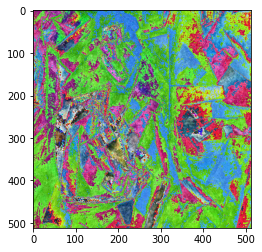

In [0]:
pt_imshow(norm(style_img))

In [0]:
# 스타일/콘텐츠 로스로 계산하길 원하는 깊이의 레이어들:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [0]:
def get_style_model_and_losses(cnn_model_trained, 
                               normalization_mean, normalization_std,
                               style_img, content_img,
                               style_layers = style_layers_default,
                               content_layers = content_layers_default,):
  
  cnn_model = copy.deepcopy(cnn_model_trained)

  normalization = Normalization(normalization_mean, normalization_std)

  content_losses = []
  style_losses = []

  model = nn.Sequential(normalization)
  i = 0
  for layer in cnn_model.children():
    if isinstance(layer, nn.Conv2d):
      i += 1
      name = 'conv_{}'.format(i)
    elif isinstance(layer, nn.ReLU):
      name = 'ReLU {}'.format(i)
      layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
      name = 'MaxPool2d {}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
      name = 'BatchNorm2d {}'.format(i)
    else:
      raise RuntimeError('Unrecognized layer : {}'.format(layer.__class__.__name__))

    model.add_module(name, layer)

    if name in content_layers:
      target = model(content_img)
      content_loss = ContentLoss(target)
      model.add_module('content_loss_{}'.format(i), content_loss)
      content_losses.append(content_loss)
    if name in style_layers:
      target = model(style_img)
      style_loss = StyleLoss(target)
      model.add_module('style_loss_{}'.format(i), style_loss)
      style_losses.append(style_loss)

  for i in range(len(model)-1, -1, -1):
    if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
      break

  model = model[:(i+1)]

  return model, style_losses, content_losses

In [0]:
def get_style_model_and_losses_gpu(cnn_model_trained, 
                               normalization_mean, normalization_std,
                               style_img, content_img,
                               style_layers = style_layers_default,
                               content_layers = content_layers_default,):
  
  cnn_model = copy.deepcopy(cnn_model_trained)

  normalization = Normalization(normalization_mean, normalization_std)

  content_losses = []
  style_losses = []

  model = nn.Sequential(normalization)
  i = 0
  for layer in cnn_model.children():
    if isinstance(layer, nn.Conv2d):
      i += 1
      name = 'conv_{}'.format(i)
    elif isinstance(layer, nn.ReLU):
      name = 'ReLU {}'.format(i)
      layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
      name = 'MaxPool2d {}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
      name = 'BatchNorm2d {}'.format(i)
    else:
      raise RuntimeError('Unrecognized layer : {}'.format(layer.__class__.__name__))

    model.add_module(name, layer.to(device))

    if name in content_layers:
      target = model(content_img)
      content_loss = ContentLoss(target)
      model.add_module('content_loss_{}'.format(i), content_loss)
      content_losses.append(content_loss)
    if name in style_layers:
      target = model(style_img)
      style_loss = StyleLoss(target)
      model.add_module('style_loss_{}'.format(i), style_loss)
      style_losses.append(style_loss)

  for i in range(len(model)-1, -1, -1):
    if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
      break

  model = model[:(i+1)]

  return model, style_losses, content_losses

In [0]:
class ModelWrapper(nn.Module):
  def __init__(self,
               cnn_model_trained, 
               normalization_mean, normalization_std,
               style_img, content_img,
               style_layers = style_layers_default,
               content_layers = content_layers_default,
               ):
    super(ModelWrapper, self).__init__()

    self.cnn_model_trained = cnn_model_trained
    self.normalization_mean = normalization_mean
    self.normalization_std = normalization_std
    self.style_img = style_img
    self.content_img = content_img
    self.style_layers = style_layers
    self.content_layers = content_layers

    self.model, self.style_losses, self.content_losses = get_style_model_and_losses(self.cnn_model_trained,
            self.normalization_mean, self.normalization_std, self.style_img, self.content_img)

  def get_style_model_and_losses(self):
    
    cnn_model = copy.deepcopy(self.cnn_model_trained)

    normalization = Normalization(self.normalization_mean, self.normalization_std)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)
    i = 0
    for layer in cnn_model.children():
      if isinstance(layer, nn.Conv2d):
        i += 1
        name = 'conv_{}'.format(i)
      elif isinstance(layer, nn.ReLU):
        name = 'ReLU {}'.format(i)
        layer = nn.ReLU(inplace=False)
      elif isinstance(layer, nn.MaxPool2d):
        name = 'MaxPool2d {}'.format(i)
      elif isinstance(layer, nn.BatchNorm2d):
        name = 'BatchNorm2d {}'.format(i)
      else:
        raise RuntimeError('Unrecognized layer : {}'.format(layer.__class__.__name__))

      model.add_module(name, layer)

      if name in content_layers:
        target = model(self.content_img)
        content_loss = ContentLoss(target)
        model.add_module('content_loss_{}'.format(i), content_loss)
        content_losses.append(content_loss)
      if name in style_layers:
        target = model(self.style_img)
        style_loss = StyleLoss(target)
        model.add_module('style_loss_{}'.format(i), style_loss)
        style_losses.append(style_loss)

    for i in range(len(model)-1, -1, -1):
      if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
        break

    model = model[:(i+1)]

    return model, style_losses, content_losses

  def set_norm_mean(self, new_norm_mean):
    self.normalization_mean = new_norm_mean

  def set_norm_std(self, new_norm_std):
    self.normalization_std = new_norm_std

  def set_style_img(self, new_style_img):
    self.style_img = new_style_img

  def set_content_img(self, new_content_img):
    self.content_img = new_content_img

  def forward(x):
    return x

In [0]:
_input_img = _content_img.clone()
input_img_refernce = content_img.clone()
input_img = content_img.clone()

In [0]:
input_img.shape

torch.Size([1, 3, 512, 732])

In [0]:
def get_input_optimizer(input_img):
  optimizer = optim.LBFGS([input_img.requires_grad_()])
  return optimizer

## 학습부분

In [0]:
# _model, _style_losses, _content_losses = get_style_model_and_losses(vgg19pt,
#         _cnn_normalization_mean, _cnn_normalization_std, _style_img, _content_img)

In [0]:
# model_wrapper = ModelWrapper(vgg19pt,
#         _cnn_normalization_mean, _cnn_normalization_std, _style_img, _content_img)

In [0]:
model, style_losses, content_losses = get_style_model_and_losses_gpu(vgg19pt,
        cnn_normalization_mean, cnn_normalization_std, style_img, content_img)

In [0]:
optimizer = get_input_optimizer(input_img)

In [0]:
num_steps = 300

In [0]:
style_weight=1000
content_weight=1

In [0]:
def closure():

  input_img.data.clamp_(0,1)

  optimizer.zero_grad()
  model(input_img)
  style_score = 0
  content_score = 0
  loss_score = 0

  for sl in style_losses:
    style_score += sl.loss
  for cl in content_losses:
    content_score += cl.loss

  style_score *= style_weight
  content_score *= content_weight

  loss = style_score + content_score
  loss.backward()

  if each_step % 50 == 0:
    print("run {}:".format(each_step))
    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
        style_score.item(), content_score.item()))
    print()

  return style_score + content_score

In [0]:
input_img = content_img.clone()
model, style_losses, content_losses = get_style_model_and_losses_gpu(vgg19pt,
        cnn_normalization_mean, cnn_normalization_std, style_img, content_img)
optimizer = get_input_optimizer(input_img)

In [0]:
num_steps = 300

In [0]:
for each_step in range(num_steps):
  print(each_step)
  optimizer.step(closure)

  image = input_img.cpu().clone()  # 텐서의 값에 변화가 적용되지 않도록 텐서를 복제합니다
  image = image.squeeze(0)      # 페이크 배치 차원을 제거 합니다
  image = unloader(image)
  image.save('./output_results/Style_transferred_my_to_sixpack.jpg')
  try:
    image.save('./output_results/Style_transferred_my_04.jpg')
  except:
    pass

input_img.data.clamp_(0, 1)

0
run 0:
Style Loss : 6739772.500000 Content Loss: 0.000000

run 0:
Style Loss : 6737980.500000 Content Loss: 0.000000

run 0:
Style Loss : 4481484.500000 Content Loss: 1.568706

run 0:
Style Loss : 3566657.750000 Content Loss: 1.836000

run 0:
Style Loss : 3015346.750000 Content Loss: 2.163944

run 0:
Style Loss : 2470975.250000 Content Loss: 2.922415

run 0:
Style Loss : 2034727.375000 Content Loss: 3.704503

run 0:
Style Loss : 1679986.875000 Content Loss: 4.147415

run 0:
Style Loss : 1403930.500000 Content Loss: 4.436523

run 0:
Style Loss : 1222855.750000 Content Loss: 5.011577

run 0:
Style Loss : 1054968.750000 Content Loss: 5.253155

run 0:
Style Loss : 949992.875000 Content Loss: 5.420705

run 0:
Style Loss : 854173.687500 Content Loss: 5.655528

run 0:
Style Loss : 791492.687500 Content Loss: 6.288174

run 0:
Style Loss : 695620.250000 Content Loss: 6.290244

run 0:
Style Loss : 654130.937500 Content Loss: 6.321656

run 0:
Style Loss : 606846.937500 Content Loss: 6.631961

r

KeyboardInterrupt: ignored

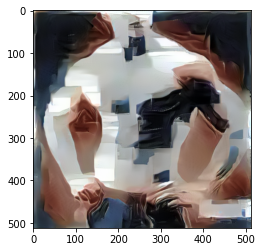

In [0]:
input_img.data.clamp_(0, 1)
pt_imshow(input_img)

In [0]:
  image = content_img.cpu().clone()  # 텐서의 값에 변화가 적용되지 않도록 텐서를 복제합니다
  image = image.squeeze(0)      # 페이크 배치 차원을 제거 합니다
  image = unloader(image)
  image.save('./output_results/Content_img.jpg')

In [0]:
  image = style_img.cpu().clone()  # 텐서의 값에 변화가 적용되지 않도록 텐서를 복제합니다
  image = image.squeeze(0)      # 페이크 배치 차원을 제거 합니다
  image = unloader(image)
  image.save('./output_results/style_img.jpg')

In [0]:
def convert(data):
    if isinstance(data, bytes):  return data.decode('ascii')
    if isinstance(data, dict):   return dict(map(convert, data.items()))
    if isinstance(data, tuple):  return map(convert, data)
    return data

In [0]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [0]:
input_img_dir = './drive/My Drive/Colab Notebooks/mlstudy/gan/gdl_code/data/apple2orange_npy/'

In [0]:
input_img_dir_trainA = './drive/My Drive/Colab Notebooks/mlstudy/gan/gdl_code/data/apple2orange_npy/imgs_trainA.npy'
_trainA = np.load(input_img_dir_trainA)

input_img_dir_trainB = './drive/My Drive/Colab Notebooks/mlstudy/gan/gdl_code/data/apple2orange_npy/imgs_trainB.npy'
_trainB = np.load(input_img_dir_trainB)

input_img_dir_testA = './drive/My Drive/Colab Notebooks/mlstudy/gan/gdl_code/data/apple2orange_npy/imgs_testA.npy'
_testA = np.load(input_img_dir_testA)

input_img_dir_testB = './drive/My Drive/Colab Notebooks/mlstudy/gan/gdl_code/data/apple2orange_npy/imgs_testB.npy'
_testB = np.load(input_img_dir_testB)

In [0]:
trainA = _trainA.transpose(0,3,1,2)/255
trainB = _trainB.transpose(0,3,1,2)/255
testA = _testA.transpose(0,3,1,2)/255
testB = _testB.transpose(0,3,1,2)/255

## Architecture

In [0]:
class Generator_unet(nn.Module):
  def __init__(self, filters, unet_depth):
    super(Generator_unet, self).__init__()

    self.filters = filters
    self.unet_depth = unet_depth

    self.unet_down_layers = nn.Sequential()

    self.unet_dict_down = nn.ModuleDict()
    self.unet_dict_down_norm = nn.ModuleDict()
    self.unet_dict_up = nn.ModuleDict()
    self.unet_dict_up_norm = nn.ModuleDict()

    self.unet_dict_upsample = nn.ModuleDict()

    self.downsample_filters_list = []
    for i in range(self.unet_depth):
      in_filters = self.filters*(i+1)
      out_filters = self.filters*(i+2)
      conv = nn.Conv2d(in_filters, 
                        out_filters, 
                        kernel_size = 5, 
                        stride = 2, 
                        padding = 2
                        )
      self.unet_dict_down['Layer {}'.format(i+1)] = conv
      norm = nn.InstanceNorm2d(out_filters)
      self.unet_dict_down_norm['Layer {}'.format(i+1)] = norm
      # print(out_filters)
      self.downsample_filters_list.append(out_filters)

    self.downsample_filters_list.reverse()

    for i, j in zip(range(self.unet_depth), self.downsample_filters_list):
      if i==0:
        in_filters = j
        prev_j = j
      else:
        in_filters = j * 2
        prev_j = j
      out_filters = self.filters*(self.unet_depth-i)
      conv = nn.Conv2d(in_filters, 
                        out_filters, 
                        kernel_size = 5, 
                        stride = 1, 
                        padding = 2
                        )
      self.unet_dict_up['Layer {}'.format(i+1)] = conv
      norm = nn.InstanceNorm2d(out_filters)
      self.unet_dict_up_norm['Layer {}'.format(i+1)] = norm

    for i in range(self.unet_depth):
      conv = nn.Upsample(scale_factor=2)
      self.unet_dict_upsample['Layer {}'.format(i+1)] = conv
  
    self.tanh_layer = nn.Tanh()

  def forward(self, x):

    d_output_dict = {}
    for i in range(self.unet_depth):
      d = self.unet_dict_down['Layer {}'.format(i+1)]
      x = d(x)
      norm = self.unet_dict_down_norm['Layer {}'.format(i+1)]
      x = norm(x)
      x = nn.ReLU()(x)

      d_output_dict[i] = x

    # print(x.shape)
    for i in range(self.unet_depth-1):
      u_upsample = self.unet_dict_upsample['Layer {}'.format(i+1)]
      u = self.unet_dict_up['Layer {}'.format(i+1)]
      x = u_upsample(x)
      # print(x.shape)
      x = u(x)
      norm = self.unet_dict_up_norm['Layer {}'.format(i+1)]
      x = norm(x)
      x = nn.ReLU()(x)
      d_to_concat = d_output_dict[self.unet_depth-i-2]

      # print(x.shape, d_to_concat.shape)

      x = torch.cat([x, d_to_concat], dim=1)

      # print(x.shape)

      # print('\n')
    
    u = self.unet_dict_upsample['Layer {}'.format(self.unet_depth)]

    x = u(x)

    x = self.unet_dict_up['Layer {}'.format(self.unet_depth)](x)
    output_x = self.tanh_layer(x)

    return output_x

In [0]:
class Generator_resnet(nn.Module):
  def __init__(self, ):
    super(Generator_resnet, self).__init__()

In [0]:
class Discriminator_PT(nn.Module): # GAN Pytorch
  def __init__(self,
               input_filter,
               layer_filter,
               num_layers
               ):

    super(Discriminator_PT, self).__init__()

    self.name = 'cgan'

    self.input_filter = input_filter
    self.layer_filter = layer_filter
    self.num_layers = num_layers

    self.current_filter = self.input_filter

    ## discriminator
    self.discriminator_conv_layers = nn.Sequential()
    self._build_discriminator()
    
  def _build_discriminator(self):
    for i in range(self.num_layers):
      out_filter = self.current_filter * 2
      conv2d = nn.Conv2d(self.current_filter, 
                         out_filter,
                         kernel_size = (4,4), 
                         stride = 2, 
                         padding = 1
                         )
      current_layer_name = 'Layer {}'.format(i)
      self.discriminator_conv_layers.add_module(
                current_layer_name,
                conv2d
            )
      norm = nn.InstanceNorm2d(out_filter)
      self.discriminator_conv_layers.add_module(
                'Layer norm {}'.format(i),
                norm
            )
      self.discriminator_conv_layers.add_module(
                'Layer LeakyReLU {}'.format(i),
                nn.LeakyReLU()
            )
      self.current_filter = out_filter

    self.discriminator_conv_layers.add_module(
        'Layer last',
        nn.Conv2d(out_filter, 1, 4, 1, 0)
    )
    self.discriminator_conv_layers.add_module(
        'Custom Padding',
        nn.ConstantPad2d((1,2,1,2), value = 0)
    )

  def forward(self, x):

    x = self.discriminator_conv_layers(x)

    return x


In [0]:
dcgan = Discriminator_PT(3, 32, 4).to(device)

In [0]:
ptsum(dcgan, (3, 256, 256,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 128, 128]             294
    InstanceNorm2d-2          [-1, 6, 128, 128]               0
         LeakyReLU-3          [-1, 6, 128, 128]               0
            Conv2d-4           [-1, 12, 64, 64]           1,164
    InstanceNorm2d-5           [-1, 12, 64, 64]               0
         LeakyReLU-6           [-1, 12, 64, 64]               0
            Conv2d-7           [-1, 24, 32, 32]           4,632
    InstanceNorm2d-8           [-1, 24, 32, 32]               0
         LeakyReLU-9           [-1, 24, 32, 32]               0
           Conv2d-10           [-1, 48, 16, 16]          18,480
   InstanceNorm2d-11           [-1, 48, 16, 16]               0
        LeakyReLU-12           [-1, 48, 16, 16]               0
           Conv2d-13            [-1, 1, 13, 13]             769
    ConstantPad2d-14            [-1, 1,

In [0]:
class CycleGAN(nn.Module):
  def __init__(self,
               g_AB, g_BA,
               d_A, d_b,
               ):
    super(CycleGAN, self).__init__()
    self.g_AB = g_AB
    self.g_BA = g_BA
    self.d_A = d_A
    self.d_B = d_B

  def forward(self, img_A, img_B):
    
    fake_A = self.g_BA(img_B)
    fake_B = self.g_AB(img_A)

    # discriminator should discriminate fake images well
    valid_A = self.d_A(fake_A)
    valid_B = self.d_A(fake_B)

    # reconstructed image should have high quality
    reconstr_A = self.g_BA(fake_B)
    reconstr_B = self.g_AB(fake_A)

    # Real image should not be transferred differently, because it already has the style.
    img_A_id = self.g_BA(img_A)
    img_B_id = self.g_AB(img_B)

    return valid_A, valid_B, reconstr_A, reconstr_B, img_A_id, img_B_id

In [0]:
class generaters_combined(nn.Module):
  def __init__(self, g_A, g_B):
    super(generaters_combined, self).__init__()

    self.g_A = g_A
    self.g_B = g_B

In [0]:
class discriminators_combined(nn.Module):
  def __init__(self, d_A, d_B):
    super(discriminators_combined, self).__init__()

    self.d_A = d_A
    self.d_B = d_B

In [0]:
trainA_pt = torch.from_numpy(trainA).float().to(device)
trainB_pt = torch.from_numpy(trainB).float().to(device)

In [0]:
testA_pt = torch.from_numpy(testA).float().to(device)
testB_pt = torch.from_numpy(testB).float().to(device)

In [0]:
g_AB = Generator_unet(3, 5).to(device)
g_BA = Generator_unet(3, 5).to(device)

In [0]:
d_A = Discriminator_PT(3, 32, 4).to(device)
d_B = Discriminator_PT(3, 32, 4).to(device)

In [0]:
# g_combined = generaters_combined(g_AB, g_BA)
# d_combined = discriminators_combined(d_A, d_B)

In [0]:
# g_AB_optimizer = optim.Adam(g_AB.parameters(), 0.0002)
# g_BA_optimizer = optim.Adam(g_BA.parameters(), 0.0002)

In [0]:
g_optimizer = optim.Adam(itertools.chain(g_AB.parameters(), g_BA.parameters()), 0.0002)

In [0]:
d_A_optimizer = optim.Adam(d_A.parameters(), 0.0002)
d_B_optimizer = optim.Adam(d_B.parameters(), 0.0002)

In [0]:
EPOCHS = 50

In [0]:
for epoch in tqdm(range(EPOCHS)):
  
  g_AB.train()
  g_BA.train()
  d_A.train()
  d_B.train()

  for _img_A, _img_B in zip(DataLoader(trainA_pt, 32, False), DataLoader(trainB_pt, 32, False)):
    if (_img_A.shape[0] != _img_B.shape[0]):
      continue
    else:

      img_A = _img_A
      img_B = _img_B
      mini_batch_size = img_A.shape[0]
      fake_A = g_BA(img_B)
      fake_B = g_AB(img_A)

      # discriminator should discriminate fake images well
      valid_A_fake = d_A(fake_A)
      valid_B_fake = d_B(fake_B)

      # reconstructed image should have high quality
      reconstr_A = g_BA(fake_B)
      reconstr_B = g_AB(fake_A)

      # Real image should not be transferred differently, because it already has the style.
      img_A_id = g_BA(img_A)
      img_B_id = g_AB(img_B)

      d_A_real = d_A(img_A)
      d_B_real = d_A(img_B)
      
      valid = torch.ones([mini_batch_size, 1, 16, 16]).to(device)
      fake = torch.zeros([mini_batch_size, 1, 16, 16]).to(device)

      g_optimizer.zero_grad()

      valid_loss_A = ((valid - valid_A_fake)**2).mean()
      valid_loss_B = ((valid - valid_B_fake)**2).mean()
      reconstr_loss_A = (img_A - reconstr_A).abs().mean()
      reconstr_loss_B = (img_B - reconstr_B).abs().mean()
      identity_loss_A = (img_A - img_A_id).abs().mean()
      identity_loss_B = (img_B - img_B_id).abs().mean()

      g_loss = 1/6 * (valid_loss_A + valid_loss_B + reconstr_loss_A + reconstr_loss_B + identity_loss_A + identity_loss_B)

      g_loss.backward()
      g_optimizer.step()
      # g_AB_optimizer.step()
      # g_BA_optimizer.step()



      fake_A = g_BA(img_B)
      fake_B = g_AB(img_A)

      valid_A_fake = d_A(fake_A)
      valid_B_fake = d_B(fake_B)
      valid_A_real = d_A(img_A)
      valid_B_real = d_B(img_B)
      
      d_A_loss_real = ((valid_A_real - valid)**2).mean()
      d_A_loss_fake = ((valid_A_fake - fake)**2).mean()
      d_A_optimizer.zero_grad()
      d_loss = (d_A_loss_real + d_A_loss_fake)/2
      d_loss.backward()
      d_A_optimizer.step()

      d_B_loss_real = ((valid_B_real - valid)**2).mean()
      d_B_loss_fake = ((valid_B_fake - fake)**2).mean()
      d_B_optimizer.zero_grad()
      d_loss = (d_B_loss_real + d_B_loss_fake)/2
      d_loss.backward()
      d_B_optimizer.step()

      # d_A_loss = (d_A_loss_real + d_A_loss_fake)/2
      # d_B_loss = (d_B_loss_real + d_B_loss_fake)/2

      # d_A_loss.backward()
      # d_A_optimizer.step()


      # d_B_loss.backward()
      # d_B_optimizer.step()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


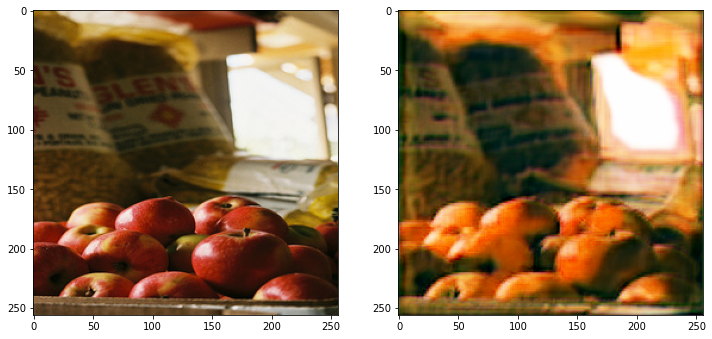

In [0]:
sample = testA[[4]]
sample_np = sample.transpose(0,2,3,1)
sample_pt = torch.from_numpy(sample).float().to(device)
sample_A2B = g_AB(sample_pt)
sample_A2B_np = sample_A2B.cpu().detach().numpy().transpose(0,2,3,1)
fig, axes = plt.subplots(1,2, figsize=(12,6))
ax, ax02 = axes[0], axes[1]
ax.imshow(sample_np[0])
ax02.imshow(sample_A2B_np[0])

In [0]:
## generator 는 똑같다.

class Generator_PT(nn.Module): # GAN Pytorch
    def __init__(self
        , generator_initial_dense_layer_size
        , input_dim
        , generator_upsample
        , generator_conv_filters
        , generator_conv_kernel_size
        , generator_conv_strides
        , generator_batch_norm_momentum
        , generator_activation
        , generator_dropout_rate
        , generator_learning_rate
        , optimiser
        , z_dim
        , discriminator_output_shape
        , discriminator_cnn_output_shape
        ):
        
        super(Generator_PT, self).__init__()

        # Necessary information from discriminator
        self.discriminator_output_shape = discriminator_output_shape
        self.discriminator_cnn_output_shape = discriminator_cnn_output_shape
        
        self.name = 'gan'
        self.input_dim = input_dim
        
        ## generator
        self.generator_initial_dense_layer_size = generator_initial_dense_layer_size
        self.generator_upsample = generator_upsample
        self.generator_conv_filters_input = [self.generator_initial_dense_layer_size[0]] + generator_conv_filters[:-1]
        self.generator_conv_filters_output = generator_conv_filters
        self.generator_conv_kernel_size = generator_conv_kernel_size
        self.generator_conv_strides = generator_conv_strides
        self.generator_batch_norm_momentum = generator_batch_norm_momentum
        self.generator_activation = generator_activation
        self.generator_dropout_rate = generator_dropout_rate
        self.generator_learning_rate = generator_learning_rate
        
        self.z_dim = z_dim

        self.n_layers_generator = len(generator_conv_filters)

        # initializer
        self.weight_init = torch.normal(mean=torch.Tensor([0.]), std=0.02)

        self.d_losses = []
        self.g_losses = []

        self.epoch = 0
                
        self.generator_conv_layers = nn.Sequential()
        self.generator_output_shape = collections.OrderedDict()
        
        self.generator_initial_layers = nn.Sequential()
        
        self.generator_output_shape['Input'] = self.input_dim
        self.generator_output_shape['Input'] = self.generator_initial_dense_layer_size


        self._build_generator()

    def get_activation(self, activation):
        if activation == 'leaky_relu':
            layer = LeakyReLU(alpha = 0.2)
        else:
            layer = Activation(activation)
        return layer

    def _build_generator(self):

        print('Build Generator')
        ### THE generator

        self.generator_initial_layers.add_module('Layer Generator Input', 
                                            nn.Linear(self.z_dim, np.prod(self.generator_initial_dense_layer_size)))

        self.generator_initial_layers.add_module('Layer Generator Input LeakyReLU', nn.LeakyReLU())
        
        if self.generator_dropout_rate:
            self.generator_initial_layers.add_module('Layer Generator Input Dropout2d', nn.Dropout2d(p=self.generator_dropout_rate))
            
        # 이건 forward가서
#         x = Reshape(self.generator_initial_dense_layer_size)(x)
        
        current_layer_name = 'Input'
        current_input_shape = self.generator_output_shape[current_layer_name]
        
        discriminator_conv_layer_name_list = []
        
#         print(self.discriminator_output_shape)
        
        for item in self.discriminator_output_shape:
            discriminator_conv_layer_name_list.append(item)
        discriminator_conv_layer_name_list.reverse()

#         print(discriminator_conv_layer_name_list)
        for i, discriminator_layer_name in zip(range(self.n_layers_generator), discriminator_conv_layer_name_list[1:]):
            
#             print(discriminator_layer_name)
            
            discriminator_layer_shape = self.discriminator_output_shape[discriminator_layer_name]
            
            current_filter, input_H, input_W = discriminator_layer_shape
            current_layer_name = 'Layer {} Conv2d'.format(i)

        
            if self.generator_upsample[i] == 2:
                
                current_filter, input_H, input_W = current_input_shape
                
                input_H = input_H*self.generator_upsample[i]
                input_W = input_W*self.generator_upsample[i]
                
                current_layer_name = 'Layer {} Conv2d'.format(i)

                kernel_H, kernel_W = self.generator_conv_kernel_size[i]
                stride_H, stride_W  = self.generator_conv_strides[i]

                _output_H = int((input_H-kernel_H)/stride_H) + 1
                _output_W = int((input_W-kernel_W)/stride_W) + 1

                target_output_H = int(input_H/stride_H)
                target_output_W = int(input_W/stride_W)

                if target_output_H != _output_H:
                    padding_H = int(np.ceil(((target_output_H-1)*stride_H-input_H+kernel_H)/2))
                else:
                    padding_H = 0

                if target_output_W != _output_W:
                    padding_W = int(np.ceil(((target_output_W-1)*stride_W-input_W+kernel_W)/2))
                else:
                    padding_W = 0

                output_H = int((input_H-kernel_H+2*padding_H)/stride_H) + 1
                output_W = int((input_W-kernel_W+2*padding_W)/stride_W) + 1
                
                self.generator_output_shape[current_layer_name] = [self.generator_conv_filters_output[i], output_H, output_W]
                current_input_shape = self.generator_output_shape[current_layer_name]
                

                self.generator_conv_layers.add_module('Layer {} Upsample'.format(i),
                                            nn.Upsample(scale_factor=self.generator_upsample[i])
                                           )
                

                self.generator_conv_layers.add_module(
                    current_layer_name,
                    nn.Conv2d(
                            self.generator_conv_filters_input[i]
                            , self.generator_conv_filters_output[i]
                            , kernel_size = self.generator_conv_kernel_size[i]
                            , stride = self.generator_conv_strides[i]
                            , padding = (padding_H, padding_W)
    #                         , kernel_initializer = self.weight_init
                            )
                )
                
            else:
                
                # defining size
                current_filter, input_H, input_W = current_input_shape
                current_layer_name = 'Layer {} Conv2d'.format(i)

                kernel_H, kernel_W = self.generator_conv_kernel_size[i]
                stride_H, stride_W = self.generator_conv_strides[i]

                target_output_H = max(input_H*stride_H,discriminator_layer_shape[1])
                target_output_W = max(input_W*stride_W,discriminator_layer_shape[2])

                padding_output_padding_H = (input_H - 1) * stride_H + (kernel_H - 1) + 1 - target_output_H
                padding_output_padding_W = (input_W - 1) * stride_W + (kernel_W - 1) + 1 - target_output_W
                
                if padding_output_padding_H%2==0:
                    output_padding_H = 0
                    padding_H = int(padding_output_padding_H/2)
                else:
                    output_padding_H = max(stride_H-1,0)
                    padding_H = int((padding_output_padding_H+output_padding_H)/2)
                    
                if padding_output_padding_W%2==0:
                    output_padding_W = 0
                    padding_W = int(padding_output_padding_W/2)
                else:
                    output_padding_W = max(stride_W-1,0)
                    padding_W = int((padding_output_padding_W+output_padding_W)/2)

                # padding_H = max(0, padding_H)
                # padding_W = max(0, padding_W)
                    
                output_H = (input_H-1)*stride_H + (kernel_H-1)+1 - 2 * padding_H + output_padding_H
                output_W = (input_W-1)*stride_W + (kernel_W-1)+1 - 2 * padding_W + output_padding_W

                self.generator_output_shape[current_layer_name] = [self.generator_conv_filters_output[i], output_H, output_W]
                current_input_shape = self.generator_output_shape[current_layer_name]
                
                # print('\n')
                # print(output_H, target_output_H, padding_H, output_padding_H, stride_H, kernel_H)

                # self.output_shape[current_layer_name] = [self.generator_conv_filters_output[i], output_H, output_W]
                # current_input_shape = self.output_shape[current_layer_name]

                self.generator_conv_layers.add_module(current_layer_name,
                                nn.ConvTranspose2d(self.generator_conv_filters_input[i]
                                        , self.generator_conv_filters_output[i]
                                        , kernel_size = self.generator_conv_kernel_size[i]
                                        , stride = self.generator_conv_strides[i]
                                        , padding = (padding_H, padding_W)
                                        , output_padding = (output_padding_H, output_padding_W)
                                        ))

            print(output_H, output_W, padding_H, padding_W)
                
            if i < self.n_layers_generator - 1:

                if self.generator_batch_norm_momentum:
                    self.generator_conv_layers.add_module('Layer {} BatchNorm2d'.format(i), 
                                                nn.BatchNorm2d(self.generator_conv_filters_output[i],
                                                              momentum=self.generator_batch_norm_momentum))

                self.generator_conv_layers.add_module('Layer {} LeakyReLU'.format(i), nn.LeakyReLU())
                    
                
            # else:

            self.tanh = nn.Tanh()


        # 이 부분도 forward로
#         generator_output = x

#         self.generator = Model(generator_input, generator_output)


    def forward(self, x):
        
        
        x = self.generator_initial_layers(x)
        # print(x.shape)
        
        x = x.reshape([x.size()[0]]+list(self.generator_initial_dense_layer_size))
        
        x = self.generator_conv_layers(x)
        x = self.tanh(x)
        
        return x



In [0]:
z_dim = 100

In [0]:
input_dim = (3, 32, 32)

In [0]:
activation_function = 'Sigmoid'

In [0]:
activation_function = 'WGAN'

In [0]:
activation_function = 'WGANGP'

In [0]:
if activation_function == 'Sigmoid':
  discriminator_learning_rate = 0.0008
  generator_learning_rate = 0.0004
else:
  discriminator_learning_rate = 0.00005
  generator_learning_rate = 0.00005

device = 'cpu'

In [0]:
Discriminator = Discriminator_PT(
    input_dim = input_dim
    , discriminator_conv_filters = [32,64,128,128]
    , discriminator_conv_kernel_size = [(5,5),(5,5),(5,5),(5,5)]
    , discriminator_conv_strides = [(2,2),(2,2),(2,2),(1,1)]
    , discriminator_batch_norm_momentum = 0.5
    , discriminator_activation = 'relu'
    , discriminator_dropout_rate = 0.4
    , discriminator_learning_rate = discriminator_learning_rate
    , optimiser = 'rmsprop'
    , z_dim = z_dim
    , activation_function = activation_function
    ).to(device)

Build Discriminator
16 16
8 8
4 4
4 4


In [0]:
Generator = Generator_PT(
    input_dim = input_dim
    , generator_initial_dense_layer_size = (128, 4, 4)
    , generator_upsample = [2,2, 2, 1]
    , generator_conv_filters = [128,64, 64,3]
    , generator_conv_kernel_size = [(5,5),(5,5),(5,5),(5,5)]
    , generator_conv_strides = [(1,1),(1,1), (1,1), (1,1)]
    , generator_batch_norm_momentum = 0.8
    , generator_dropout_rate = 0.25
    , generator_activation = 'relu'
    , generator_learning_rate = generator_learning_rate
    , optimiser = 'rmsprop'
    , z_dim = z_dim
    , discriminator_output_shape = Discriminator.discriminator_output_shape
    , discriminator_cnn_output_shape = Discriminator.discriminator_cnn_output_shape
    ).to(device)

Build Generator
8 8 2 2
16 16 2 2
32 32 2 2
32 32 2 2


## 학습

In [0]:
Discriminator.train()
Generator.train()
print('Train mode')

Train mode


In [0]:
# Binary Cross Entropy loss
criterion = nn.BCELoss().to(device)

# 생성자의 매개 변수를 최적화하는 Adam optimizer
G_optimizer = optim.RMSprop(Generator.parameters(), lr=Generator.generator_learning_rate)
# 구분자의 매개 변수를 최적화하는 Adam optimizer
D_optimizer = optim.RMSprop(Discriminator.parameters(), 
                            lr=Discriminator.discriminator_learning_rate)

# optim.RMSprop
# optim.Adam

In [0]:
x_train_pt = torch.from_numpy(x_train).float().to(device)

In [0]:
EPOCHS = 1

In [0]:
batch_size = 128

In [0]:
for epoch in range(EPOCHS):
    
    for real_data in tqdm(DataLoader(x_train_pt, batch_size = batch_size, shuffle=True)):
      pass

In [0]:
EPOCHS = 5000

## activation_function

이것이 'None'이면 WGAN이다.

In [0]:
print(activation_function)

WGANGP


In [0]:
CLIP_THRESHOLD = 0.01

In [0]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.from_numpy(np.random.random((real_samples.size(0), 1, 1, 1))).to(device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates.float())
    fake = torch.ones(real_samples.shape[0], 1).to(device)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

```
D, real_samples, fake_samples = Discriminator, real_data.data, fake_data.data

alpha = torch.from_numpy(np.random.random((real_samples.size(0), 1, 1, 1))).to(device)
# Get random interpolation between real and fake samples
interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
d_interpolates = D(interpolates.float())
fake = torch.ones(real_samples.shape[0], 1).to(device)
# Get gradient w.r.t. interpolates
gradients = autograd.grad(
    outputs=d_interpolates,
    inputs=interpolates,
    grad_outputs=fake,
    create_graph=True,
    retain_graph=True,
    only_inputs=True,
)[0]
gradients = gradients.view(gradients.size(0), -1)
gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
```

In [0]:
if activation_function == 'Sigmoid':
  discriminator_train_number = 1
else:
  discriminator_train_number = 5

https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan_gp/wgan_gp.py

## Clipping 시키는 예시

https://github.com/Zeleni9/pytorch-wgan/blob/master/models/wgan_clipping.py

In [0]:
# Loss weight for gradient penalty
lambda_gp = 10

In [0]:
print(activation_function)

WGANGP


In [0]:
restart_epoch = 0

In [0]:
try:
  restart_epoch = epoch
except:
  restart_epoch = 0

for epoch in range(restart_epoch, EPOCHS):
  
  total_D_loss = 0
  total_G_loss = 0
  
  batch_count_for_generator = 0
  # for real_data in tqdm(DataLoader(x_train_pt, batch_size = batch_size, shuffle=True)):
  for real_data in DataLoader(x_train_pt, batch_size = batch_size, shuffle=True):
    # print(batch_count_for_generator)
    real_data_shape = real_data.shape[0]

    if real_data_shape!=batch_size:
      continue

    target_real = Variable(torch.ones(real_data_shape, 1)).float().to(device)

    ## 판별자
    for p in Discriminator.parameters():
      p.requires_grad = True  # to avoid computation
    for p in Generator.parameters():
      p.requires_grad = False  # to avoid computation
    D_optimizer.zero_grad()
    Discriminator.zero_grad()

    if activation_function == 'WGAN':
      for p in Discriminator.parameters():
        p.data.clamp_(-CLIP_THRESHOLD, CLIP_THRESHOLD)

    D_result_from_real = Discriminator(real_data)
    z = (torch.randn((real_data_shape, z_dim))).to(device)
    fake_data = Generator(z)
    D_result_from_fake = Discriminator(fake_data)
    
    if activation_function == 'Sigmoid':
      target_fake = Variable(torch.zeros(real_data_shape, 1)).float().to(device)

      D_loss_real = criterion(D_result_from_real, target_real)
      D_loss_fake = criterion(D_result_from_fake, target_fake)

    else:
      target_fake = Variable(torch.ones(real_data_shape, 1)).float().to(device)

      # D_loss_real = (D_result_from_real * target_real).mean()
      D_loss_real = torch.mean(D_result_from_real)
      # from fake는 fake데이터를 discriminator가 평가한것. 
      # 이것에 target_fake를 곱하면, 
      # D_loss_fake = (D_result_from_fake * target_fake).mean()
      D_loss_fake = torch.mean(D_result_from_fake)

    if activation_function == 'WGANGP':
      gradient_penalty = compute_gradient_penalty(Discriminator, real_data.data, fake_data.data)
    else:
      gradient_penalty = torch.from_numpy(np.array([0])).to(device)

    if activation_function == 'Sigmoid':
      D_loss = D_loss_real + D_loss_fake
    elif activation_function == 'WGAN':
      D_loss = -1 * (D_loss_real - D_loss_fake)
    elif activation_function == 'WGANGP':
      D_loss = -1 * (D_loss_real - D_loss_fake) + lambda_gp * gradient_penalty

    # Discriminator.zero_grad()
    D_loss.backward()
    D_optimizer.step()

    # Clipping weights
    # if activation_function == 'WGAN':
    #   for temp_layer in Discriminator.discriminator_conv_layers:
    #     if hasattr(temp_layer, 'weight'):
    #       for temp_p in temp_layer02.parameters():
    #         temp_p.data.clamp_(-CLIP_THRESHOLD, CLIP_THRESHOLD)
    #   for temp_p in Discriminator.discriminator_flattened.parameters():
    #     temp_p.data.clamp_(-CLIP_THRESHOLD, CLIP_THRESHOLD)
    


    if activation_function == 'Sigmoid':
      batch_count_for_generator = 0

    # Discriminator.train()
    # Generator.train()

    if batch_count_for_generator%5==0:
      # print('generator',batch_count_for_generator)
      for p in Discriminator.parameters():
        p.requires_grad = False  # to avoid computation
      for p in Generator.parameters():
        p.requires_grad = True  # to avoid computation
      G_optimizer.zero_grad()
      Generator.zero_grad()
      batch_count_for_generator = 0

      ## 생성자

      z = (torch.randn((real_data_shape, 100))).to(device)

      fake_data = Generator(z)

      D_result_from_fake = Discriminator(fake_data)

      if activation_function == 'Sigmoid':
        G_loss = criterion(D_result_from_fake, target_real)
      else:
        # G_loss = -1 * (D_result_from_fake * target_real).mean()
        G_loss = -1 * torch.mean(D_result_from_fake)

      G_loss.backward()
      G_optimizer.step()

      total_G_loss+=G_loss.item()

    total_D_loss+=D_loss.item()
    batch_count_for_generator+=1
    
    # print('\t', D_loss.item())
    # print('\t', G_loss.item())

  total_D_loss_numeric = round(total_D_loss,6)
  total_G_loss_numeric = round(total_G_loss,6)

  print_str = str(epoch) + ' ' + str(total_D_loss_numeric) + ' ' + str(total_G_loss_numeric)

  print(print_str)

  if epoch%10==0:
    try:
      torch.save(Discriminator.state_dict(), './drive/My Drive/Colab Notebooks/mlstudy/gan/gdl_code/trained_models/Discriminator_{}.pt'.format(activation_function))
      torch.save(Generator.state_dict(), './drive/My Drive/Colab Notebooks/mlstudy/gan/gdl_code/trained_models/Generator_{}.pt'.format(activation_function))

      Generator.eval()
      for i in range(10):
        generated_image = Generator(torch.randn([1,100]).to(device)).cpu().detach().numpy()[0].transpose(1,2,0)
        generated_image02 = (((generated_image - generated_image.min())/((generated_image - generated_image.min()).max()))*255).astype(int)
        img = Image.fromarray(np.uint8((generated_image02)))
        img.save('./drive/My Drive/Colab Notebooks/mlstudy/gan/gdl_code/fig/image_{}_{}.png'.format(activation_function, i))
      Generator.train()
      
    except:
      pass

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1 -169.334716 36.396272
2 -233.969001 35.826734
3 -410.738574 48.025122
4 -724.77668 73.798481
5 -947.564746 88.185338
6 78.759503 80.88313
7 16.816731 56.14915
8 -42.39184 56.96152
9 -68.791103 63.169453
10 -97.939616 61.872069
11 -125.486708 55.59266
12 -173.485626 57.355412
13 -210.25009 58.675388
14 -204.294724 55.494898
15 -11.446121 36.855808
16 -24.364969 41.501018
17 -44.130873 42.683252
18 -58.642381 48.465553
19 -50.118582 42.91917
20 -46.737033 40.669711
21 -66.035759 35.087871
22 -40.79384 35.498149
23 -58.229816 31.005201
24 -78.142905 34.189741
25 -70.70925 29.548682
26 -78.035837 28.703191
27 -88.476029 27.718298
28 -85.27608 24.013015
29 -82.762053 20.239281
30 -88.798384 21.287295
31 -89.818392 20.185746
32 -93.874537 21.18656
33 -100.438616 22.962656
34 -95.892794 21.318297
35 -80.893057 23.393411
36 -6.874273 9.76158
37 -24.41019 16.326273
38 -29.372256 11.890822
39 -40.825108 12.064406
40 -33.756845 9.163119
41 -30.693484 7.343691

## GAN

In [0]:
# Generator.eval()
# generated_image = Generator(torch.randn([1,100]).to(device)).cpu().detach().numpy()[0].transpose(1,2,0)
# generated_image02 = (((generated_image - generated_image.min())/((generated_image - generated_image.min()).max()))*255).astype(int)
# img = Image.fromarray(np.uint8((generated_image02)))
# Generator.train()
# try:
#   img.save('./drive/My Drive/Colab Notebooks/mlstudy/gan/gdl_code/fig/image.png')
# except:
#   pass

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


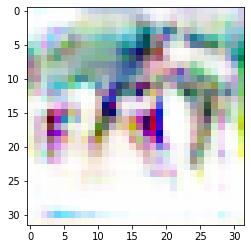

In [0]:
Generator.eval()
plt.imshow(Generator(torch.randn([1,100]).to(device)).cpu().detach().numpy()[0].transpose(1,2,0))
Generator.train()

## WGAN

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


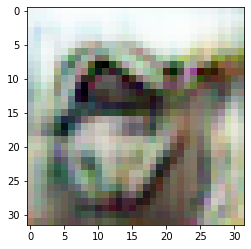

In [0]:
Generator.eval()
plt.imshow(Generator(torch.randn([1,100]).to(device)).cpu().detach().numpy()[0].transpose(1,2,0))
Generator.train()
print(1)

## WGAN-GP

In [0]:
Generator.eval()
plt.imshow(Generator(torch.randn([1,100]).to(device)).cpu().detach().numpy()[0].transpose(1,2,0))
Generator.train()
print(1)